In [38]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

from __future__ import division
import itertools
import copy
from collections import namedtuple

# Machine Learning for Face Analysis

## LCAV TAM, 27 Feb 2018

### Paolo Prandoni

## Outline

* what I do the other half of the time
* a brief demo
* paper discussion: "One Millisecond Face Alignment with an Ensemble of Regression Trees"

## A "reproducible" TAM 

* a shameful confession
* apologies for the didactic approach
* TAMs: _cui prodest?_

![quividi](quividi.png)


## Live Demo!

## Face Alignment

 * "One Millisecond Face Alignment with an Ensemble of Regression Trees", by Vahid Kazemi and Josephine Sullivan, KTH, 2014
 
<img src="faces.jpg" alt="landmarks" style="width: 800px;"/> 

## Problem setup:

* $I$: $M\times M$ face image, 8-bit, grayscale
* $S$: set of $L$ face _landmarks_, as $x, y$ coordinates; $S \in \mathbb{N}^{2L}$ 
* find $F: \mathbb{N}^{M^2} \rightarrow \mathbb{N}^{2L}$ s.t.
$F(I) \approx S$

### typical landmark pattern:
<img src="landmarks_68.png" alt="landmarks" style="width: 500px;"/>

## Classic ML problem:

* get a set of N annotated face images $\{I_n, S_n\}$
* train a system on the dataset

### typical landmark variability in training set
<img src="face_shape_model.gif" alt="landmarks" style="width: 500px;"/>

## Why Kazemi and Sullivan's approach is nice

* use intelligent "features" rather than raw data
* supplement classic boosting methods with smart ad-hoc observations
* a good mix of ML and intuition

## Ingredient 1: Gradient Boosting

Problem: learn $F(I) \approx S$

* successive refinement of estimation function: $F_{n+1}(I) = F_n(I) + h_n(I)$
* ideally: $h_n(I) = S - F_n(I)$
* learn a sequence of approximations to the _residuals_ $h_n(I)$

In our case:
* start with an estimate $\hat{S}^{(0)}$ (i.e. average face shape)
* for $i = 0, \ldots, T$:
    * compute residuals $\Delta S^{(i)}_n = S_n - \hat{S}^{(i)} \qquad n = 1, \ldots, N$
    * learn an approximation $r_i(I_n, \hat{S}^{(i)}_n) \approx \Delta S^{(i)}_n$ 
    * update estimates $\hat{S}^{(i+1)}_n = \hat{S}^{(i)}_n + r_i(I_n, \hat{S}^{(i)}_n)$
    
    
    
Note: dependence on $\hat{S}^{(i)}_n$ is important

<img src="cascade.jpg" alt="cascade" style="width: 1200px;"/>

## Ingredient 2: Regression Trees and Forests

Learning the residual estimators $r_i(I, \hat{S})$ 

* use regression trees to approximate the residual
* use boosting (again!) to avoid overfitting and improve generalization
* boosted trees are also called forests

### A brief digression on trees and forests...

### a classification tree

![classification](classification_tree.png)

### regression trees

Pievewise-constant function approximation:
* split function domain recursively 
* use function average over split intervals
* choose the split points at random via a greedy strategy that minimizes the squared error

In [52]:
class RTree:
    def __init__(self, depth):
        self.levels = depth
        self.num_leaves = 2 ** self.levels
        self.num_nodes = self.num_leaves - 1

    def train(self, data):
        N = len(data)
        TRIALS_PER_NODE = 100

        # initialize tree and go through nodes in order
        ix = 0
        self.node = [None] * (self.num_nodes + 1)  # node indexing starts at 1
        self.node[1] = {'A': 0, 'B': N}
        self.leaf = []
        for level in xrange(0, self.levels):
            for k in xrange(0, 2 ** level):
                ix += 1
                # select greedily the best split per node over N trials
                A = self.node[ix]['A']
                B = self.node[ix]['B']
                best = {'err': 1e20, 'S': A}
                for n in xrange(0, TRIALS_PER_NODE):
                    S = A + int(np.floor(np.random.rand() * (B - A + 1)))
                    err = np.square(data[A:S] - data[A:S].mean()).sum() + \
                          np.square(data[S:B] - data[S:B].mean()).sum()
                    if err < best['err']:
                        best = {'err': err, 'S': S}
                # best split found :
                S = best['S']
                self.node[ix]['S'] = S
                if level == self.levels - 1:
                    self.leaf.append(data[A:S].mean())
                    self.leaf.append(data[S:B].mean())
                else:
                    self.node[2*ix] = {'A': A, 'B': S}
                    self.node[2*ix+1] = {'A': S, 'B': B}
                    
    def regress(self, N = 1):
        x = np.zeros(N)
        for n in xrange(0, N):
            ix = 1
            for k in xrange(0, self.levels):
                if n >= self.node[ix]['S']:
                    ix = 2 * ix + 1
                else:
                    ix = 2 * ix
            x[n] = self.leaf[ix - self.num_nodes - 1]
        return x

In [53]:
def test_fit(data, regressor):
    t = eval(regressor)
    t.train(data)
    plt.plot(data)
    plt.plot(t.regress(len(data)), linewidth=5.0)

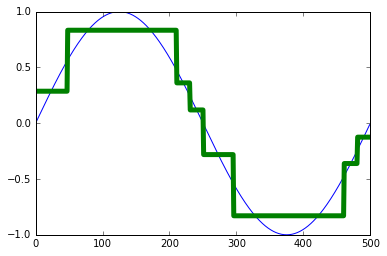

In [54]:
POINTS = 500
x = np.sin(np.arange(0, POINTS) * 2 * np.pi / POINTS)

test_fit(x, 'RTree(3)')

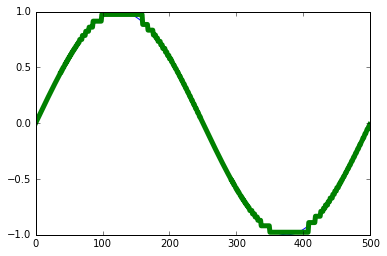

In [55]:
test_fit(x, 'RTree(8)')

### boosting the trees

* trees that are too deep are prone to overfitting (low bias, high variance)
* better to use a forest of shallow trees via boosting
* boosting reduces variance by correcting past classification mistakes

### training a forest



In [43]:
class RForest:
    def __init__(self, forest_size, tree_depth, nu):
        self.num_trees = forest_size
        self.tree_depth = tree_depth
        self.nu = nu

    def train(self, data):
        self.trees = []
        residual = data.copy()
        for k in xrange(0, self.num_trees):
            rt = RTree(self.tree_depth)
            rt.train(residual)
            self.trees.append(rt)
            residual = residual - self.nu * rt.regress(len(residual))

    def regress(self,  N=1):
        x = np.zeros(N)
        for rt in self.trees:
            x = x + self.nu * rt.regress(N)
        return x            

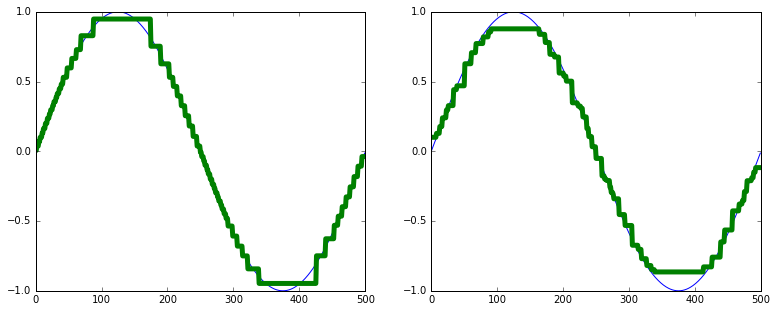

In [44]:
plt.subplots(1, 2, figsize=(13, 5))
plt.subplot(1,2,1)
test_fit(x, 'RTree(6)')
plt.subplot(1,2,2)
test_fit(x, 'RForest(8, 3, 0.3)')

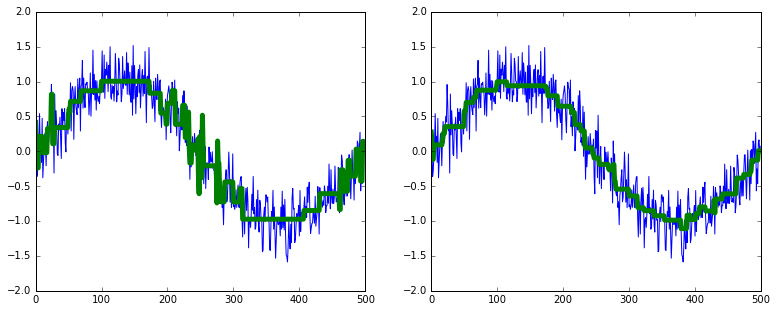

In [51]:
y = x + np.random.randn(POINTS) / 4
plt.subplots(1, 2, figsize=(13, 5))
plt.subplot(1,2,1)
test_fit(y, 'RTree(6)')
plt.subplot(1,2,2)
test_fit(y, 'RForest(8, 3, 0.4)')

### Back to our problem...

Learn a forest regressor to approximate $r_i(I_n, \hat{S}^{(i)}_n) \approx \Delta S^{(i)}_n$

* use $I$ and $\hat{S}$ at each stage to produce a pool of $P$ pixel-based binary tests (features)
* tests will be used as split nodes in the trees
* each tree will select different features from the list
* use boosting to combine trees into a forest

### greedy training strategy:

For each node in the tree:
* repeat $C$ times:
    * select a test at random from the pool, split the training set in two subsets
    * compute the average residuals $\bar{\Delta S}_{L}, \bar{\Delta S}_{R}$ for the two sets
    * compute the total MSE resulting from approximating the residuals by their averages
* select the test yielding the lowest MSE

Use the tree boosting algorithm to combine $K$ trees into a forest

## Ingredient 3: "shape-invariant" features

Feature: $\{\mathbf{x, y}, \theta\}$
* $\mathbf{x, y}$ pair of random pixel coordinates
* $\theta$ random threshold

Binary test: $I(\mathbf{x}) - I(\mathbf{y}) > \theta$

Feature pool: set of $P$ random features, with a prior favoring nearby pairs of pixels

#### Shape invariance:

* feature coordinates are given with respect to reference average shape $\hat{S}^{(0)}$
* at each stage in the cascade:
    * find warping from $\hat{S}^{(0)}$ to $\hat{S}^{(i)}$
    * warp feature coordinates
* stage-based warping ensures computational efficiency

## Other neat ideas
* augment training set by mixing
* result always linear combination of shapes